# Transfer Learning with EfficientNetV2-S (PyTorch)

## 1. Imports, seeds and paths

In [ ]:
import os
import sys
import random
import time
from pathlib import Path
import glob

import numpy as np
import pandas as pd

cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    normalize_splits,
    format_duration,
    build_classification_report,
    compute_classification_metrics,
    compute_confusion_matrix,
    log_metrics_to_csv,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

# Fallback for mixed TF/PyTorch CUDA environments in WSL:
# expose CUDA/cuDNN libs from the dedicated PyTorch venv before importing torch
torch_venv = Path('/home/user/venvs/cifar10-torch')
if torch_venv.exists():
    py_ver = f"python{sys.version_info.major}.{sys.version_info.minor}"
    torch_site = torch_venv / 'lib' / py_ver / 'site-packages'
    nvidia_lib_dirs = glob.glob(str(torch_site / 'nvidia' / '*' / 'lib'))
    wsl_lib = '/usr/lib/wsl/lib'
    parts = [wsl_lib] + nvidia_lib_dirs
    existing = os.environ.get('LD_LIBRARY_PATH', '')
    if existing:
        parts.append(existing)
    os.environ['LD_LIBRARY_PATH'] = ':'.join(parts)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import EfficientNet_V2_S_Weights

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Python executable: {sys.executable}')
print(f'Torch version: {torch.__version__}')
print(f'Torch path: {torch.__file__}')
print(f'Torch CUDA runtime: {torch.version.cuda}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    print('CUDA not available in current kernel. Select kernel: cifar10-torch (PyTorch).')

Using device: cuda
Python executable: /home/user/venvs/cifar10-torch/bin/python
Torch version: 2.10.0+cu128
Torch path: /home/user/venvs/cifar10-torch/lib/python3.12/site-packages/torch/__init__.py
Torch CUDA runtime: 12.8
GPU: NVIDIA GeForce RTX 4060 Ti


In [2]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.lower() != 'cifar10_project' and (PROJECT_ROOT / 'cifar10_project').is_dir():
    PROJECT_ROOT = PROJECT_ROOT / 'cifar10_project'

DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_DIR = PROJECT_ROOT / 'reports'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

data_path = PROCESSED_DIR / 'cifar10_processed.npz'
performance_report_path = DATA_DIR / 'model_performance_report.csv'

print('Data path:', data_path)
print('Performance report path:', performance_report_path)

Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data

In [ ]:
data = np.load(data_path)

x_train = data['x_train'].astype(np.float32)
y_train = np.squeeze(data['y_train']).astype(np.int64)
x_val = data['x_val'].astype(np.float32)
y_val = np.squeeze(data['y_val']).astype(np.int64)
x_test = data['x_test'].astype(np.float32)
y_test = np.squeeze(data['y_test']).astype(np.int64)

splits = normalize_splits({
    'x_train': x_train,
    'x_val': x_val,
    'x_test': x_test,
}, scale=255.0, dtype='float32', clip_range=(0.0, 1.0))
x_train, x_val, x_test = splits['x_train'], splits['x_val'], splits['x_test']

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

print('Train:', x_train.shape, y_train.shape)
print('Val:  ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

Train: (40000, 32, 32, 3) (40000,)
Val:   (10000, 32, 32, 3) (10000,)
Test:  (10000, 32, 32, 3) (10000,)


## 3. Data pipeline with resizing to 96x96

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 64
NUM_WORKERS = 2

mean = [0.485, 0.456, 0.406]                            #mean of data inside the 3 RGB layers
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),             #resize, horizontal flip
    transforms.RandomResizedCrop(
        size=IMG_SIZE,
        scale=(0.85, 1.0),
        ratio=(1.0, 1.0),
    ),
    transforms.ColorJitter(                             #adjusting color, brightness
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02,
    ),
    transforms.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),                  
    transforms.Normalize(mean=mean, std=std),               #normalise across mean, std
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(mean=mean, std=std),
])

class CifarArrayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).permute(2, 0, 1).float()
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_ds = CifarArrayDataset(x_train, y_train, transform=train_transform)
val_ds = CifarArrayDataset(x_val, y_val, transform=eval_transform)
test_ds = CifarArrayDataset(x_test, y_test, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print('Batch shape:', xb.shape, yb.shape)

Batch shape: torch.Size([64, 3, 96, 96]) torch.Size([64])


## 4. Build EfficientNetV2-S transfer learning model

In [5]:
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


## 5. Train helpers

In [ ]:
def run_epoch(model, loader, criterion, optimizer=None):                
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, labels)
            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc


def fit_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience, stage_name):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = -1.0
    best_state = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        scheduler.step(val_acc)

        print(f'[{stage_name}] Epoch {epoch:03d}/{epochs} | '
              f'train_loss={train_loss:.4f} train_acc={train_acc:.4f} | '
              f'val_loss={val_loss:.4f} val_acc={val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'[{stage_name}] Early stopping triggered.')
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history

## 6. Stage 1 training (feature extraction)

In [7]:
epochs_stage1 = 30
initial_lr = 1e-3

criterion_stage1 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_stage1 = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=initial_lr)
scheduler_stage1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_stage1, mode='max', factor=0.5, patience=3, min_lr=1e-6
)

train_start_time = time.time()
history_stage1 = fit_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_stage1,
    optimizer=optimizer_stage1,
    scheduler=scheduler_stage1,
    epochs=epochs_stage1,
    patience=3,
    stage_name='stage1'
)

[stage1] Epoch 001/30 | train_loss=1.6885 train_acc=0.4953 | val_loss=1.4211 val_acc=0.6150
[stage1] Epoch 002/30 | train_loss=1.5792 train_acc=0.5419 | val_loss=1.3994 val_acc=0.6266
[stage1] Epoch 003/30 | train_loss=1.5831 train_acc=0.5414 | val_loss=1.3980 val_acc=0.6242
[stage1] Epoch 004/30 | train_loss=1.5730 train_acc=0.5451 | val_loss=1.3869 val_acc=0.6262
[stage1] Epoch 005/30 | train_loss=1.5834 train_acc=0.5376 | val_loss=1.9981 val_acc=0.6253
[stage1] Early stopping triggered.


## 7. Stage 2 training (fine-tuning)

In [8]:
for param in model.features.parameters():
    param.requires_grad = True

fine_tune_at = len(model.features) // 2
for block_idx, block in enumerate(model.features):
    if block_idx < fine_tune_at:
        for param in block.parameters():
            param.requires_grad = False

epochs_stage2 = 80
fine_tune_lr = 1e-4

criterion_stage2 = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer_stage2 = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=fine_tune_lr)
scheduler_stage2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_stage2, mode='max', factor=0.2, patience=8, min_lr=1e-9
)

history_stage2 = fit_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_stage2,
    optimizer=optimizer_stage2,
    scheduler=scheduler_stage2,
    epochs=epochs_stage2,
    patience=8,
    stage_name='stage2'
)

train_duration_sec = time.time() - train_start_time
print(f'Training time: {train_duration_sec:.2f} sec')

[stage2] Epoch 001/80 | train_loss=0.7063 train_acc=0.8429 | val_loss=0.5211 val_acc=0.9281
[stage2] Epoch 002/80 | train_loss=0.4699 train_acc=0.9330 | val_loss=0.5008 val_acc=0.9451
[stage2] Epoch 003/80 | train_loss=0.4089 train_acc=0.9568 | val_loss=0.4108 val_acc=0.9535
[stage2] Epoch 004/80 | train_loss=0.3764 train_acc=0.9684 | val_loss=0.4720 val_acc=0.9497
[stage2] Epoch 005/80 | train_loss=0.3549 train_acc=0.9761 | val_loss=0.5407 val_acc=0.9497
[stage2] Epoch 006/80 | train_loss=0.3405 train_acc=0.9809 | val_loss=0.4037 val_acc=0.9546
[stage2] Epoch 007/80 | train_loss=0.3310 train_acc=0.9848 | val_loss=0.4178 val_acc=0.9512
[stage2] Epoch 008/80 | train_loss=0.3266 train_acc=0.9858 | val_loss=0.4094 val_acc=0.9553
[stage2] Epoch 009/80 | train_loss=0.3219 train_acc=0.9875 | val_loss=0.4135 val_acc=0.9548
[stage2] Epoch 010/80 | train_loss=0.3178 train_acc=0.9892 | val_loss=0.4286 val_acc=0.9538
[stage2] Epoch 011/80 | train_loss=0.3168 train_acc=0.9891 | val_loss=0.4206 val

## 8. Evaluation, plots and logging

In [9]:
def merge_histories(h1, h2):
    out = {}
    for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
        out[key] = h1.get(key, []) + h2.get(key, [])
    return out


def predict_loader(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            logits = model(images)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(labels.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

EfficientNetV2-S test accuracy: 0.9551
Classification Report (EfficientNetV2-S):
              precision    recall  f1-score   support

    airplane     0.9721    0.9750    0.9735      1000
  automobile     0.9699    0.9660    0.9679      1000
        bird     0.9594    0.9460    0.9527      1000
         cat     0.8906    0.9280    0.9089      1000
        deer     0.9567    0.9510    0.9539      1000
         dog     0.9403    0.8820    0.9102      1000
        frog     0.9675    0.9830    0.9752      1000
       horse     0.9642    0.9690    0.9666      1000
        ship     0.9723    0.9840    0.9781      1000
       truck     0.9593    0.9670    0.9631      1000

    accuracy                         0.9551     10000
   macro avg     0.9552    0.9551    0.9550     10000
weighted avg     0.9552    0.9551    0.9550     10000



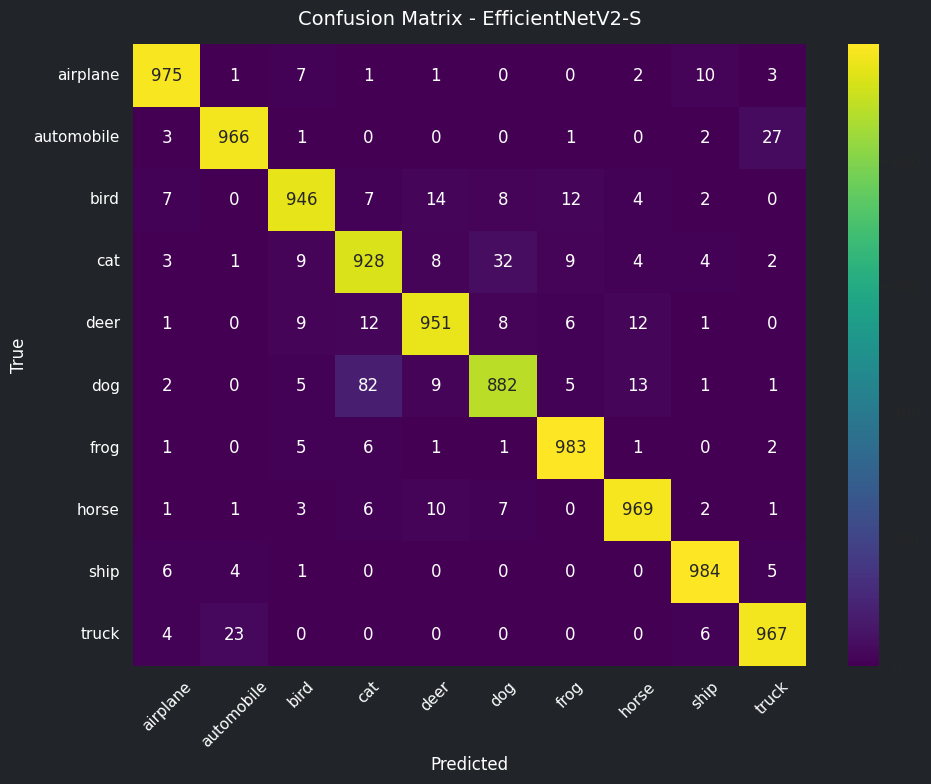

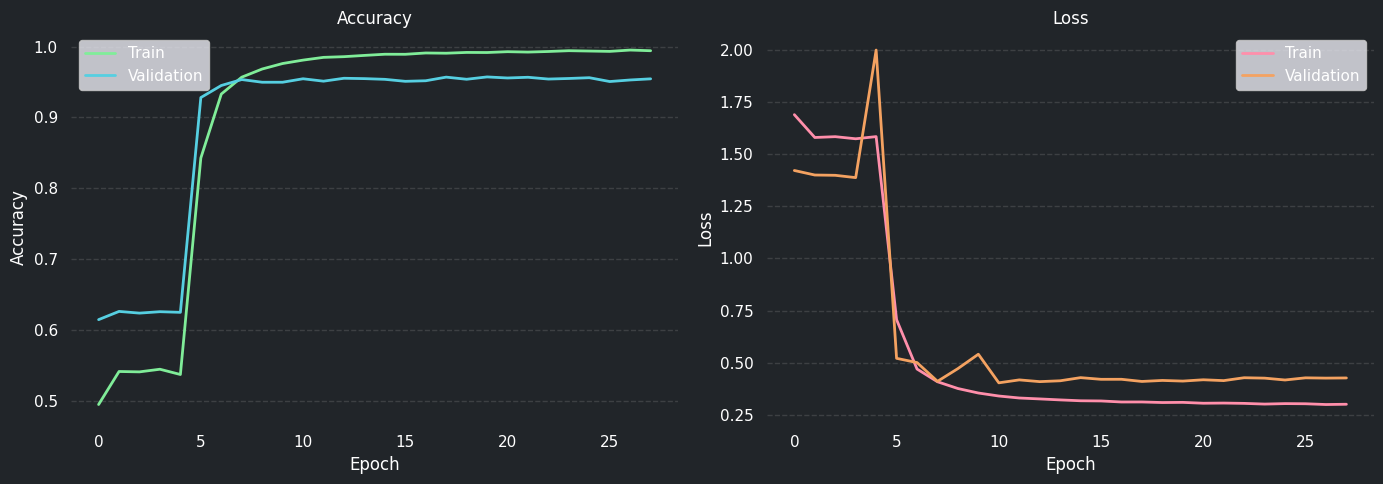

Logged metrics: {'model_name': 'EfficientNetV2S Transfer Learning (PyTorch)', 'num_params': 20190298, 'train_time_sec': 1306.37, 'train_time': '21 min 46 sec', 'timestamp': '2026-02-20 08:35', 'accuracy': 0.9551, 'precision': 0.9552385477375778, 'recall': 0.9551000000000001, 'f1': 0.955019595347971, 'support': 10000, 'final_accuracy': 0.994125, 'final_loss': 0.30104102225303647, 'final_val_accuracy': 0.9545, 'final_val_loss': 0.4270802080154419, 'final_learning_rate': 0.0001, 'epochs_trained': 28, 'test_loss': 0.18517478238344193, 'framework': 'pytorch'}
Saved model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetv2s_cifar10_tuned.pt
Saved confusion matrix to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/efficientnetv2s_confusion.png
Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScienc

In [13]:
try:
    build_classification_report
    compute_classification_metrics
    compute_confusion_matrix
    log_metrics_to_csv
    plot_confusion_matrix_notebook01
    plot_training_curves_notebook01
    format_duration
except NameError:
    import sys
    from pathlib import Path

    cwd = Path.cwd()
    if cwd.name.lower() == "notebooks":
        project_root = cwd.parent
    elif cwd.name.lower() == "cifar10_project":
        project_root = cwd
    elif (cwd / "cifar10_project").is_dir():
        project_root = cwd / "cifar10_project"
    else:
        project_root = None

    if project_root is not None and str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))

    from utils.ml_utils import (
        build_classification_report,
        compute_classification_metrics,
        compute_confusion_matrix,
        log_metrics_to_csv,
        plot_confusion_matrix_notebook01,
        plot_training_curves_notebook01,
        format_duration,
    )

test_loss, test_acc = run_epoch(model, test_loader, nn.CrossEntropyLoss(), optimizer=None)
print(f'EfficientNetV2-S test accuracy: {test_acc:.4f}')

y_true, y_pred = predict_loader(model, test_loader)
print('Classification Report (EfficientNetV2-S):')
print(build_classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = compute_confusion_matrix(y_true, y_pred)
conf_path = REPORTS_DIR / 'efficientnetv2s_confusion.png'
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - EfficientNetV2-S',
    save_path=conf_path,
    dpi=300,
 )

history_all = merge_histories(history_stage1, history_stage2)
curves_path = REPORTS_DIR / 'efficientnetv2s_curves.png'
plot_training_curves_notebook01(
    history=history_all,
    save_path=curves_path,
    dpi=300,
 )

metrics = compute_classification_metrics(y_true, y_pred, average='macro')
epochs_done = len(history_all['accuracy'])
num_params = int(sum(p.numel() for p in model.parameters()))

final_lr = None
for group in optimizer_stage2.param_groups:
    final_lr = float(group['lr'])
    break

row = {
    'model_name': 'EfficientNetV2S Transfer Learning (PyTorch)',
    'num_params': num_params,
    'train_time_sec': float(round(train_duration_sec, 2)),
    'train_time': format_duration(train_duration_sec),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1': float(metrics['f1']),
    'support': int(metrics['support']),
    'final_accuracy': float(history_all['accuracy'][-1]) if history_all['accuracy'] else None,
    'final_loss': float(history_all['loss'][-1]) if history_all['loss'] else None,
    'final_val_accuracy': float(history_all['val_accuracy'][-1]) if history_all['val_accuracy'] else None,
    'final_val_loss': float(history_all['val_loss'][-1]) if history_all['val_loss'] else None,
    'final_learning_rate': final_lr,
    'epochs_trained': int(epochs_done),
    'test_loss': float(test_loss),
    'framework': 'pytorch',
}

_ = log_metrics_to_csv(performance_report_path, row, append=True)
print('Logged metrics:', row)

model_path = MODELS_DIR / 'efficientnetv2s_cifar10_tuned.pt'
torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names}, model_path)
print('Saved model to:', model_path)
print('Saved confusion matrix to:', conf_path)
print('Saved curves to:', curves_path)

target = 0.97
if metrics['accuracy'] >= target:
    print('Target reached: >= 97% accuracy ✅')
else:
    print(f"Target not reached yet: {metrics['accuracy']:.4%} < {target:.0%}")